In [ ]:
from theano.sandbox import cuda

In [31]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [32]:
model_path = 'data/imdb/models/'

## Setup data

We're going to look at the IMDB dataset, which contains movie reviews from IMDB, along with their sentiment. Keras comes with some helpers for this dataset.

In [34]:
from keras.datasets import imdb
idx = imdb.get_word_index()

Exception: URL fetch failure on https://s3.amazonaws.com/text-datasets/imdb_word_index.pkl: None -- [Errno 110] Connection timed out

This is the word list:

In [ ]:
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

...and this is the mapping from id to word

In [ ]:
idx2word = {v: k for k, v in idx.iteritems()}

We download the reviews using code copied from keras.datasets:

In [ ]:
path = get_file('imdb_full.pkl',
                origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                md5_hash='d091312047c43cf9e4e38fef92437263')
f = open(path, 'rb')
(x_train, labels_train), (x_test, labels_test) = pickle.load(f)

In [ ]:
len(x_train)

Here's the 1st review. As you see, the words have been replaced by ids. The ids can be looked up in idx2word.

In [ ]:
', '.join(map(str, x_train[0]))

The first word of the first review is 23022. Let's see what that is.

In [ ]:
idx2word[23022]

Here's the whole review, mapped from ids to words.

In [ ]:
' '.join([idx2word[o] for o in x_train[0]])

The labels are 1 for positive, 0 for negative.

In [ ]:
labels_train[:10]

Reduce vocab size by setting rare words to max index.

In [ ]:
vocab_size = 5000

trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_train]
test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_test]

Look at distribution of lengths of sentences.

In [ ]:
lens = np.array(map(len, trn))
(lens.max(), lens.min(), lens.mean())

Pad (with zero) or truncate each sentence to make consistent length.

In [ ]:
seq_len = 500

trn = sequence.pad_sequences(trn, maxlen=seq_len, value=0)
test = sequence.pad_sequences(test, maxlen=seq_len, value=0)

This results in nice rectangular matrices that can be passed to ML algorithms. Reviews shorter than 500 words are pre-padded with zeros, those greater are truncated.

In [ ]:
trn.shape

## Create simple models

### Single hidden layer NN

The simplest model that tends to give reasonable results is a single hidden layer net. So let's try that. Note that we can't expect to get any useful results by feeding word ids directly into a neural net - so instead we use an embedding to replace them with a vector of 32 (initially random) floats for each word in the vocab.

In [ ]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

The [stanford paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) that this dataset is from cites a state of the art accuracy (without unlabelled data) of 0.883. So we're short of that, but on the right track.

### Single conv layer with max pooling

A CNN is likely to work better, since it's designed to take advantage of ordered data. We'll need to use a 1D CNN, since a sequence of words is 1D.

In [ ]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [ ]:
conv1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

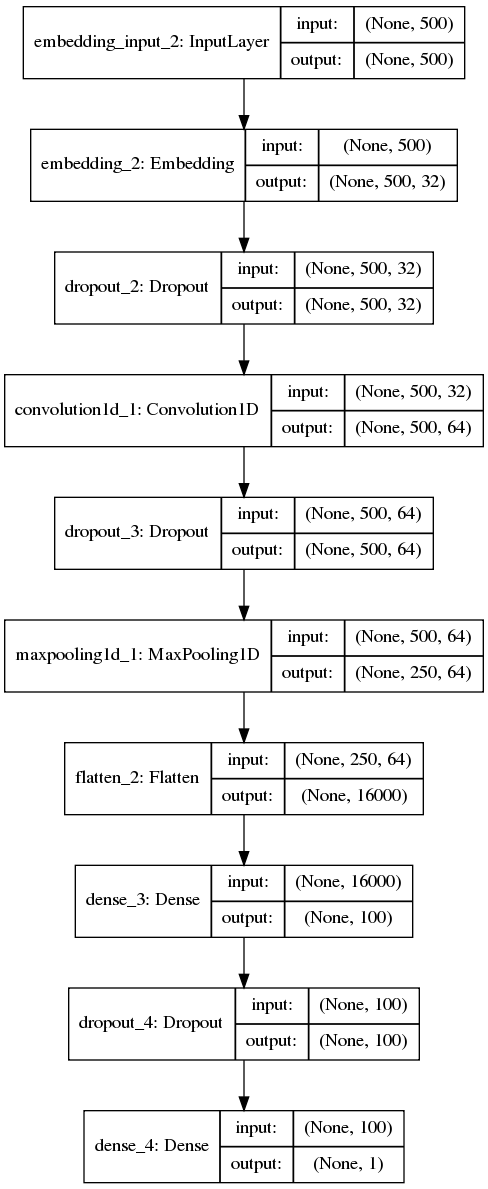

In [18]:
from keras.utils.visualize_util import plot
plot(conv1, to_file='conv1.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv1.png')

In [ ]:
conv1.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=4, batch_size=64)

That's well past the Stanford paper's accuracy - another win for CNNs!

In [ ]:
conv1.save_weights(model_path + 'conv1.h5')

In [ ]:
conv1.load_weights(model_path + 'conv1.h5')

## Pre-trained vectors

You may want to look at wordvectors.ipynb before moving on.

In this section, we replicate the previous CNN, but using pre-trained embeddings.

In [ ]:
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

In [ ]:
vecs, words, wordidx = load_vectors('data/glove/results/6B.50d')

The glove word ids and imdb word ids use different indexes. So we create a simple function that creates an embedding matrix using the indexes from imdb, and the embeddings from glove (where they exist).

In [ ]:
def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [ ]:
emb = create_emb()

We pass our embedding matrix to the Embedding constructor, and set it to non-trainable.

In [20]:
model = Sequential([
#     Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2, 
#               weights=[emb], trainable=False),
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2, 
            trainable=False),
    Dropout(0.25),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [21]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

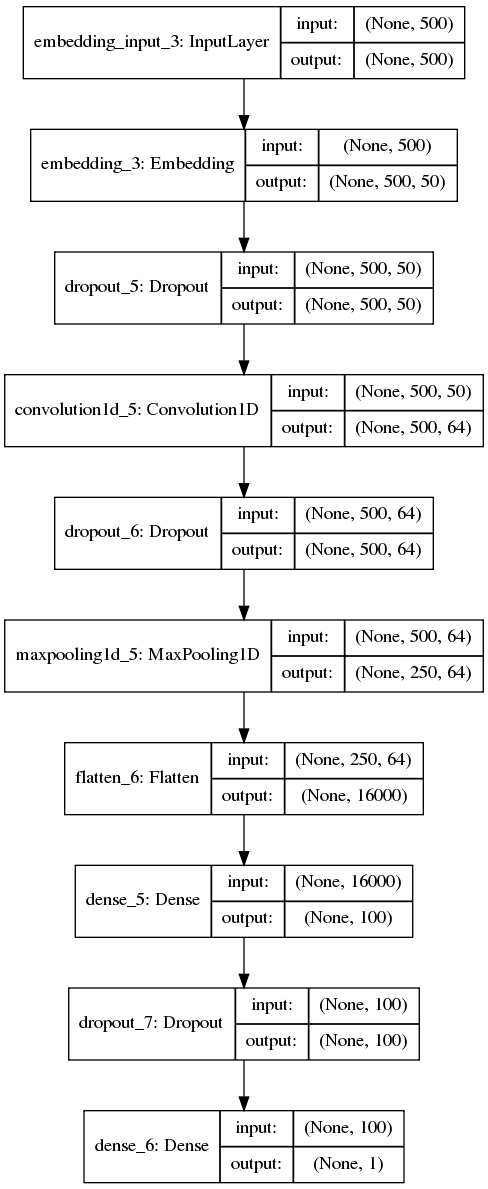

In [22]:
from keras.utils.visualize_util import plot
plot(model, to_file='single_cnn.png', show_shapes=True)
from IPython.display import Image
Image(filename='single_cnn.png')

In [ ]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

We already have beaten our previous model! But let's fine-tune the embedding weights - especially since the words we couldn't find in glove just have random embeddings.

In [ ]:
model.layers[0].trainable=True

In [ ]:
model.optimizer.lr=1e-4

In [ ]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=1, batch_size=64)

As expected, that's given us a nice little boost. :)

In [ ]:
model.save_weights(model_path+'glove50.h5')

## Multi-size CNN

This is an implementation of a multi-size CNN as shown in Ben Bowles' [excellent blog post](https://quid.com/feed/how-quid-uses-deep-learning-with-small-data).

In [23]:
from keras.layers import Merge

We use the functional API to create multiple conv layers of different sizes, and then concatenate them.

In [24]:
graph_in = Input ((vocab_size, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Merge(mode="concat")(convs) 
graph = Model(graph_in, out) 

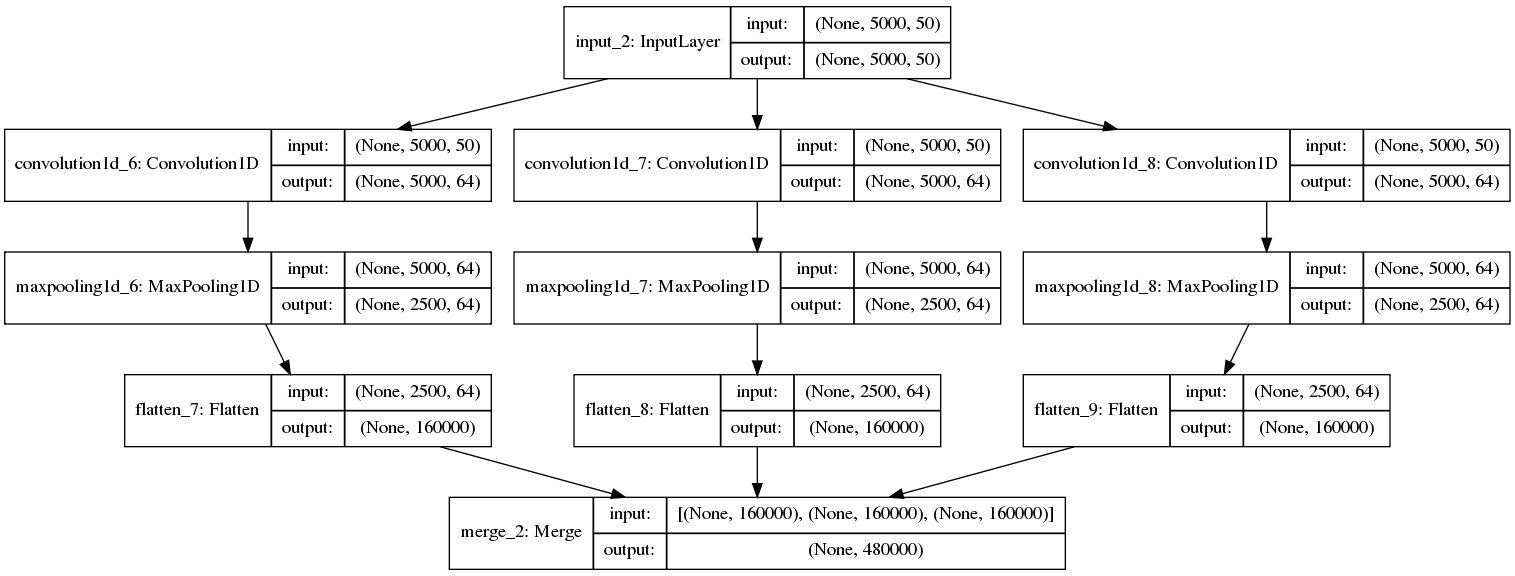

In [29]:
from keras.utils.visualize_util import plot
plot(graph, to_file='graph.png', show_shapes=True)
from IPython.display import Image
Image(filename='graph.png')

In [ ]:
emb = create_emb()

We then replace the conv/max-pool layer in our original CNN with the concatenated conv layers.

In [26]:
model = Sequential ([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2),#, weights=[emb]),
    Dropout (0.2),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.7),
    Dense (1, activation='sigmoid')
    ])

In [27]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

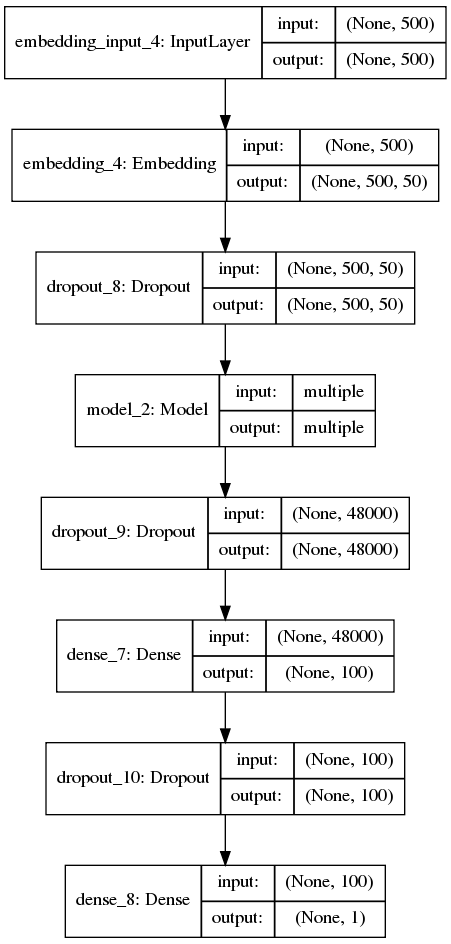

In [28]:
from keras.utils.visualize_util import plot
plot(model, to_file='multi_cnn.png', show_shapes=True)
from IPython.display import Image
Image(filename='multi_cnn.png')

In [ ]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

Interestingly, I found that in this case I got best results when I started the embedding layer as being trainable, and then set it to non-trainable after a couple of epochs. I have no idea why!

In [ ]:
model.layers[0].trainable=False

In [ ]:
model.optimizer.lr=1e-5

In [ ]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=64)

This more complex architecture has given us another boost in accuracy.

## LSTM

We haven't covered this bit yet!

In [ ]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, mask_zero=True,
              W_regularizer=l2(1e-6), dropout=0.2),
    LSTM(100, consume_less='gpu'),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=5, batch_size=64)